C:\Users\ridva\AppData\Local\Temp\ipykernel_82800\3432957148.py:9: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  dataset = pd.read_csv('merged_dataset.csv', parse_dates=['Date'], index_col='Date')


Training with units=50, dropout_rate=0.2, optimizer=adam, epochs=5, batch_size=10
Score: 0.10033954679965973
Training with units=50, dropout_rate=0.2, optimizer=adam, epochs=5, batch_size=20
Score: 0.09621135145425797
Training with units=50, dropout_rate=0.2, optimizer=adam, epochs=10, batch_size=10
Score: 0.11728180944919586
Training with units=50, dropout_rate=0.2, optimizer=adam, epochs=10, batch_size=20
Score: 0.11930470913648605
Training with units=50, dropout_rate=0.2, optimizer=rmsprop, epochs=5, batch_size=10
Score: 0.1027035117149353
Training with units=50, dropout_rate=0.2, optimizer=rmsprop, epochs=5, batch_size=20
Score: 0.12195900827646255
Training with units=50, dropout_rate=0.2, optimizer=rmsprop, epochs=10, batch_size=10
Score: 0.09729111939668655
Training with units=50, dropout_rate=0.2, optimizer=rmsprop, epochs=10, batch_size=20
Score: 0.11371208727359772
Training with units=50, dropout_rate=0.5, optimizer=adam, epochs=5, batch_size=10
Score: 0.12742196023464203
Trai

1/1 [==============================] - 0s 15ms/step


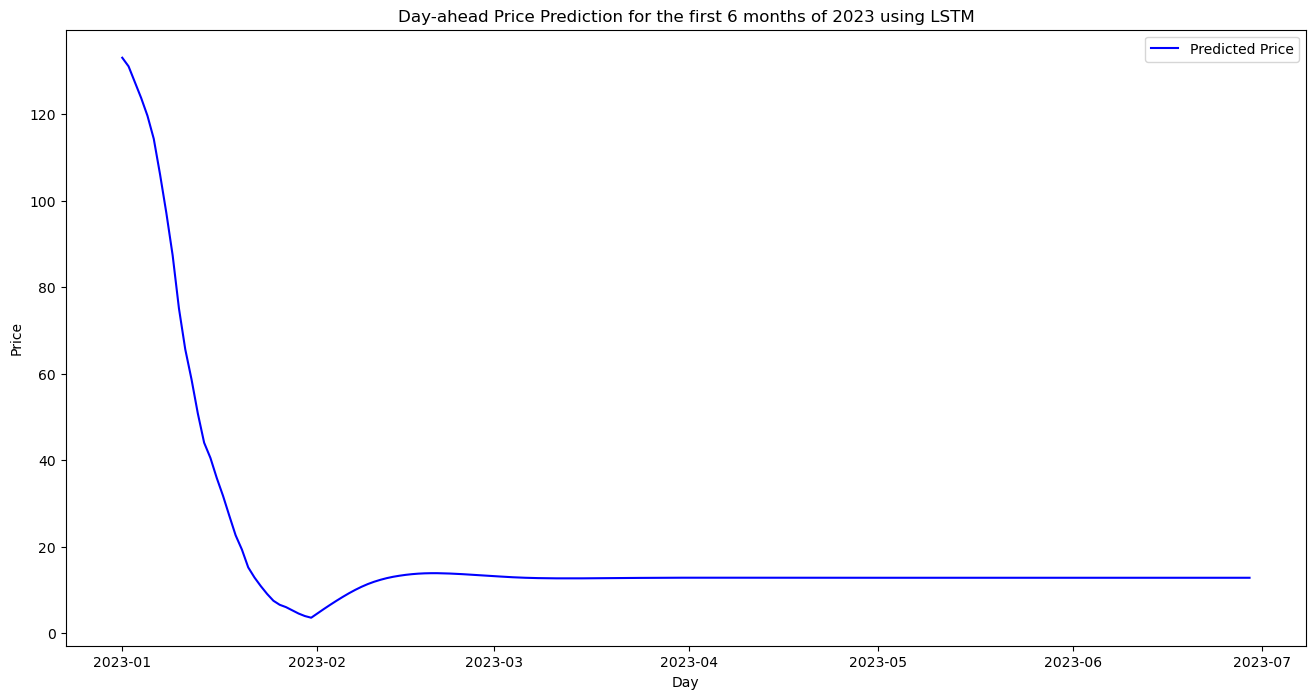

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt

# Load the dataset
dataset = pd.read_csv('merged_dataset.csv', parse_dates=['Date'], index_col='Date')

# Separate features and target
features = dataset.drop(columns=['Day_ahead_Price'])
target = dataset['Day_ahead_Price']

# Scale the features and target data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1,1))

# Split the data into training and testing sets
train_size = int(len(scaled_features) * 0.80)
train_features, test_features = scaled_features[0:train_size, :], scaled_features[train_size:len(scaled_features), :]
train_target, test_target = scaled_target[0:train_size, :], scaled_target[train_size:len(scaled_features), :]

# Reshape data for LSTM
time_steps = 30

# Create sequences for training data
X_train = []
y_train = []
for i in range(time_steps, len(train_features)):
    X_train.append(train_features[i-time_steps:i])
    y_train.append(train_target[i])

train_features = np.array(X_train)
train_target = np.array(y_train)

# Create sequences for test data
X_test = []
y_test = []
for i in range(time_steps, len(test_features)):
    X_test.append(test_features[i-time_steps:i])
    y_test.append(test_target[i])

test_features = np.array(X_test)
test_target = np.array(y_test)

# Define a function to create the LSTM model
def create_model(units, dropout_rate, optimizer):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(time_steps, train_features.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Define a grid of hyperparameters to search
param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.2, 0.5],
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [5, 10],
    'batch_size': [10, 20],
}

# Perform a grid search
best_score = np.inf
best_params = None
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for optimizer in param_grid['optimizer']:
            for epochs in param_grid['epochs']:
                for batch_size in param_grid['batch_size']:
                    print(f"Training with units={units}, dropout_rate={dropout_rate}, optimizer={optimizer}, epochs={epochs}, batch_size={batch_size}")
                    model = create_model(units, dropout_rate, optimizer)
                    model.fit(train_features, train_target, epochs=epochs, batch_size=batch_size, verbose=0)
                    score = model.evaluate(test_features, test_target, verbose=0)
                    print(f"Score: {score}")
                    if score < best_score:
                        best_score = score
                        best_params = {'units': units, 'dropout_rate': dropout_rate, 'optimizer': optimizer, 'epochs': epochs, 'batch_size': batch_size}

# Print the best parameters
print("Best: %f using %s" % (best_score, best_params))

# Fit the model with the best parameters
model = create_model(best_params['units'], best_params['dropout_rate'], best_params['optimizer'])
model.fit(train_features, train_target, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=2)

# Predict the first 6 months of 2023
future_days = 6 * 30  # 6 months
predicted_prices = []

# Get the last 30 days of the training data
last_30_days = train_features[-1:]

for i in range(future_days):
    prediction = model.predict(last_30_days)[0][0]
    predicted_prices.append(prediction)

    # Prepare the input data for the next prediction
    next_input = np.zeros((1, time_steps, train_features.shape[2]))
    next_input[0, :-1, :] = last_30_days[0, 1:, :]
    next_input[0, -1, 0] = prediction  # assuming that the price is the first feature

    # Use the newly predicted price for the next prediction
    last_30_days = next_input

predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Plot the predicted prices
plt.figure(figsize=(16, 8))
plt.plot(pd.date_range(start='2023-01-01', periods=future_days), predicted_prices, color='blue', label='Predicted Price')
plt.title('Day-ahead Price Prediction for the first 6 months of 2023 using LSTM')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()
